<h3>輸入原影像，經過壓縮轉換，再由轉換壓縮碼，還原成類原圖</h3>

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
from glob import glob
import numpy

In [3]:
import cv2

In [4]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

In [5]:
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
from matplotlib import cm

<h3>環境設置</h3>

In [7]:
max_dim = (256, 256, 1)

kernel = numpy.array([[-1, -1, -1], [-1, 11, -1], [-1, -1, -1]])

alpha = 0.6 # Contrast control (1.0-3.0)
beta = 2 # Brightness control (0-100)

In [8]:
def read_image_file(my_image_file):
    global max_dim, kernel, alpha, beta
    
    _fish_image = cv2.imread(my_image_file, 0)
    _fish_image = cv2.filter2D(_fish_image, -1, kernel)
    _fish_image = cv2.convertScaleAbs(_fish_image.copy(), alpha=alpha, beta=beta)

    _fish_image = cv2.resize(_fish_image.copy(), max_dim[:2])
    
    return _fish_image

In [9]:
def show_image(my_image):
    global max_dim
    
    _my_image = numpy.reshape(my_image, max_dim)
    
    fig, ax = plt.subplots(dpi=120)
    
    ax.imshow(my_image, cmap='gray', interpolation='bicubic')
    ax.axis('off')
    
    plt.show()

<h3>載入魚影像檔</h3>

/home/solarwind/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/solarwind/anaconda3/envs/tensorflow/lib/python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


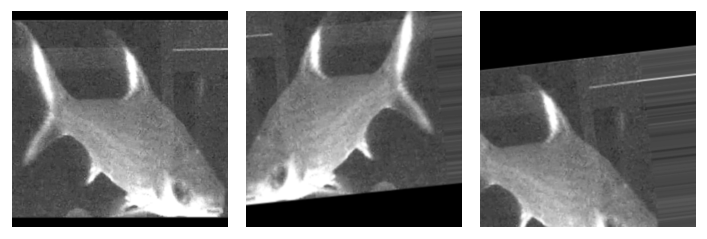

In [10]:
datagen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=45,
                             width_shift_range=[0.1, 0.2],
                             height_shift_range=[0.1, 0.2],
                             horizontal_flip=True)

_fish_image = read_image_file('images/faint/F000234-00001.jpg')

fig, ax = plt.subplots(dpi=120, ncols=3)

ax[0].imshow(_fish_image, cmap='gray', interpolation='bicubic')
ax[0].axis('off')

_fish_img_data = img_to_array(_fish_image)    
_fish_img_data = numpy.expand_dims(_fish_img_data, 0)

it = datagen.flow(_fish_img_data, batch_size=1)

for i in range(1, 3):
    _batch = it.next()
    _generated_image = _batch[0].astype('uint8')
            
    ax[i].imshow(_generated_image, cmap='gray', interpolation='bicubic')
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

In [11]:
def load_data(image_path, train_ratio=0.8):
    global max_dim

    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=45,
                                 width_shift_range=[0.1, 0.2],
                                 height_shift_range=[0.1, 0.2],
                                 horizontal_flip=True
    )
    
    image_files = glob('%s/F*.jpg' % image_path)

    my_images = []

    for image_file in image_files:
        _image_file = image_file.replace('\\', '/')
        
        _fish_image = read_image_file(_image_file)
        
        my_images.append(numpy.reshape(_fish_image, max_dim))

        _fish_img_data = img_to_array(_fish_image)    
        _fish_img_data = numpy.expand_dims(_fish_img_data, 0)
        
        it = datagen.flow(_fish_img_data, batch_size=1)

        for i in range(10):
            _batch = it.next()
            _generated_image = _batch[0].astype('uint8')
            
            my_images.append(numpy.reshape(_generated_image, max_dim))

    my_images = numpy.array(my_images)
    numpy.random.shuffle(my_images)
    
    pos = int(my_images.shape[0] * train_ratio)
    return my_images[:pos], my_images[pos:]

In [12]:
x_train, x_test = load_data(image_path='images/train')

In [13]:
x_train.shape, x_test.shape

((4488, 256, 256, 1), (1122, 256, 256, 1))

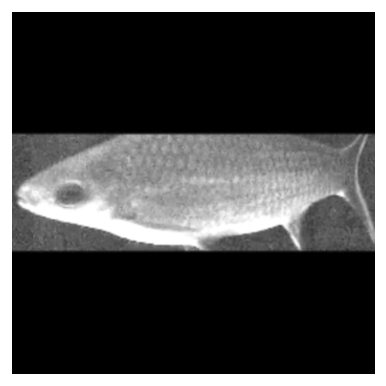

In [14]:
show_image(x_train[numpy.random.randint(len(x_train))])

<h3>將 0 ~ 255 值域，轉換為: 0 ~ 1</h3>

In [15]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

<h3>參數設置</h3>
<p>$$壓縮率: \frac {{256}*{256}={65536}}{64} = 1024$$</p>

In [16]:
encoding_dim = (32, 32, 64)

<h3>建立模型</h3>

In [17]:
input_img = keras.Input(shape=max_dim, name='input')

In [18]:
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', name='Conv2D_256')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_256')(x)

In [19]:
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='Conv2D_128')(x)
x = layers.MaxPooling2D((2, 2), padding='same', name='MaxPooling2D_128')(x)

In [20]:
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='Conv2D_64')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same', name='encoded')(x)

In [21]:
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', name='Conv2DT_64')(encoded)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_64')(x)

In [22]:
x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same', name='Conv2DT_128')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_128')(x)

In [23]:
x = layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same', name='Conv2DT_256')(x)
x = layers.UpSampling2D((2, 2), name='UpSampling2D_256')(x)

In [24]:
decoded = layers.Conv2D(1, (3, 3), padding='same', name='output')(x)

In [25]:
autoencoder = keras.Model(input_img, decoded)

In [26]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 256, 1)]     0         
_________________________________________________________________
Conv2D_256 (Conv2D)          (None, 256, 256, 256)     2560      
_________________________________________________________________
MaxPooling2D_256 (MaxPooling (None, 128, 128, 256)     0         
_________________________________________________________________
Conv2D_128 (Conv2D)          (None, 128, 128, 128)     295040    
_________________________________________________________________
MaxPooling2D_128 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
Conv2D_64 (Conv2D)           (None, 64, 64, 64)        73792     
_________________________________________________________________
encoded (MaxPooling2D)       (None, 32, 32, 64)       

In [27]:
autoencoder.compile(optimizer='adam', loss='mse')  # binary_crossentropy

<h3>訓練模型</h3>

In [28]:
checkpointer = ModelCheckpoint(
    filepath='Fish-Gray.hdf5', 
    monitor="val_loss", verbose=1, 
    save_best_only=True, mode='auto'
)

earlyStop = EarlyStopping(monitor='val_loss', patience=12)

In [29]:
num_of_epoch = 128
num_of_batch_size = 16

In [30]:
score = autoencoder.fit(x_train, x_train,
                        epochs=num_of_epoch,
                        batch_size=num_of_batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test),
                        callbacks=[checkpointer, earlyStop]
                       )

Epoch 1/128
281/281 [==============================] - ETA: 0s - loss: 0.0057
Epoch 00001: val_loss improved from inf to 0.00073, saving model to Fish-Gray.hdf5
281/281 [==============================] - 47s 169ms/step - loss: 0.0057 - val_loss: 7.2642e-04
Epoch 2/128
281/281 [==============================] - ETA: 0s - loss: 6.2487e-04
Epoch 00002: val_loss improved from 0.00073 to 0.00053, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 164ms/step - loss: 6.2487e-04 - val_loss: 5.3155e-04
Epoch 3/128
281/281 [==============================] - ETA: 0s - loss: 5.1477e-04
Epoch 00003: val_loss improved from 0.00053 to 0.00048, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 164ms/step - loss: 5.1477e-04 - val_loss: 4.8480e-04
Epoch 4/128
281/281 [==============================] - ETA: 0s - loss: 4.6456e-04
Epoch 00004: val_loss improved from 0.00048 to 0.00047, saving model to Fish-Gray.hdf5
281/281 [===========================

281/281 [==============================] - ETA: 0s - loss: 2.8437e-04
Epoch 00032: val_loss improved from 0.00027 to 0.00027, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 164ms/step - loss: 2.8437e-04 - val_loss: 2.7409e-04
Epoch 33/128
281/281 [==============================] - ETA: 0s - loss: 2.9569e-04
Epoch 00033: val_loss did not improve from 0.00027
281/281 [==============================] - 46s 164ms/step - loss: 2.9569e-04 - val_loss: 4.0135e-04
Epoch 34/128
281/281 [==============================] - ETA: 0s - loss: 2.7385e-04
Epoch 00034: val_loss did not improve from 0.00027
281/281 [==============================] - 46s 164ms/step - loss: 2.7385e-04 - val_loss: 2.7568e-04
Epoch 35/128
281/281 [==============================] - ETA: 0s - loss: 2.7697e-04
Epoch 00035: val_loss improved from 0.00027 to 0.00027, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 164ms/step - loss: 2.7697e-04 - val_loss: 2.6694e-04
Epoch

Epoch 66/128
281/281 [==============================] - ETA: 0s - loss: 2.4598e-04
Epoch 00066: val_loss improved from 0.00025 to 0.00024, saving model to Fish-Gray.hdf5
281/281 [==============================] - 47s 166ms/step - loss: 2.4598e-04 - val_loss: 2.4250e-04
Epoch 67/128
281/281 [==============================] - ETA: 0s - loss: 2.4145e-04
Epoch 00067: val_loss did not improve from 0.00024
281/281 [==============================] - 47s 169ms/step - loss: 2.4145e-04 - val_loss: 2.4521e-04
Epoch 68/128
281/281 [==============================] - ETA: 0s - loss: 2.4295e-04
Epoch 00068: val_loss improved from 0.00024 to 0.00024, saving model to Fish-Gray.hdf5
281/281 [==============================] - 49s 173ms/step - loss: 2.4295e-04 - val_loss: 2.3920e-04
Epoch 69/128
281/281 [==============================] - ETA: 0s - loss: 2.4252e-04
Epoch 00069: val_loss improved from 0.00024 to 0.00024, saving model to Fish-Gray.hdf5
281/281 [==============================] - 49s 173ms/ste

281/281 [==============================] - ETA: 0s - loss: 2.2997e-04
Epoch 00099: val_loss improved from 0.00022 to 0.00022, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 165ms/step - loss: 2.2997e-04 - val_loss: 2.2073e-04
Epoch 100/128
281/281 [==============================] - ETA: 0s - loss: 2.2944e-04
Epoch 00100: val_loss did not improve from 0.00022
281/281 [==============================] - 46s 164ms/step - loss: 2.2944e-04 - val_loss: 2.2457e-04
Epoch 101/128
281/281 [==============================] - ETA: 0s - loss: 2.1675e-04
Epoch 00101: val_loss improved from 0.00022 to 0.00022, saving model to Fish-Gray.hdf5
281/281 [==============================] - 46s 164ms/step - loss: 2.1675e-04 - val_loss: 2.1992e-04
Epoch 102/128
281/281 [==============================] - ETA: 0s - loss: 2.1945e-04
Epoch 00102: val_loss did not improve from 0.00022
281/281 [==============================] - 46s 164ms/step - loss: 2.1945e-04 - val_loss: 2.2041e-04
Ep

<h3>模型訓練績效</h3>

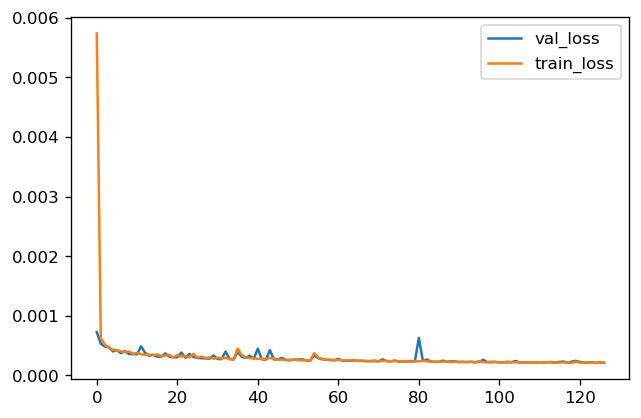

In [31]:
best_iteration = numpy.argmin(score.history['val_loss']) + 1

val_scores = score.history['val_loss'][0:best_iteration]
train_scores = score.history['loss'][0:best_iteration]

fig, ax = plt.subplots(dpi=120)

ax.plot(val_scores, label='val_loss')
ax.plot(train_scores, label='train_loss')

plt.legend(loc='upper right')
plt.show()

<h3>隨機顯示抽象圖與假圖</h3>

In [ ]:
faint_image_files = glob('%s/F*.jpg' % 'images/faint')

In [111]:
faint_image_files = glob('%s/F*.jpg' % '/mnt/Treasury/Projects/ComputerVision/Fish-ID/FISH-1/7227/V0')

In [112]:
my_faint_images = []

for image_file in faint_image_files[:24]:
    _image_file = image_file.replace('\\', '/')

    _fish_image = read_image_file(_image_file)

    my_faint_images.append(numpy.reshape(_fish_image, max_dim))

my_faint_images = numpy.array(my_faint_images)

In [113]:
my_faint_images = my_faint_images.astype('float32') / 255.
my_faint_images = numpy.reshape(my_faint_images, (my_faint_images.shape[0],) + max_dim)

In [114]:
my_faint_images.shape

(24, 256, 256, 1)

<h3>產生假圖</h3>

In [115]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer("encoded").output)

encoded_imgs = encoder.predict(my_faint_images)
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), 256, 256, 1))

In [116]:
decoded_imgs = autoencoder.predict(my_faint_images)

<h3>顯示原圖與假圖</h3>

In [96]:
def find_faint_file_pos(my_image_id=None):
    pos = -1
    
    if my_image_id is None:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
    else:
        for j in range(len(faint_image_files)):
            image_file = faint_image_files[j]
            if my_image_id in image_file:
                pos = j
                break
            
    if pos == -1:
        pos = numpy.random.randint(0, my_faint_images.shape[0], 1)[0]
        
    return pos

In [117]:
i = find_faint_file_pos()

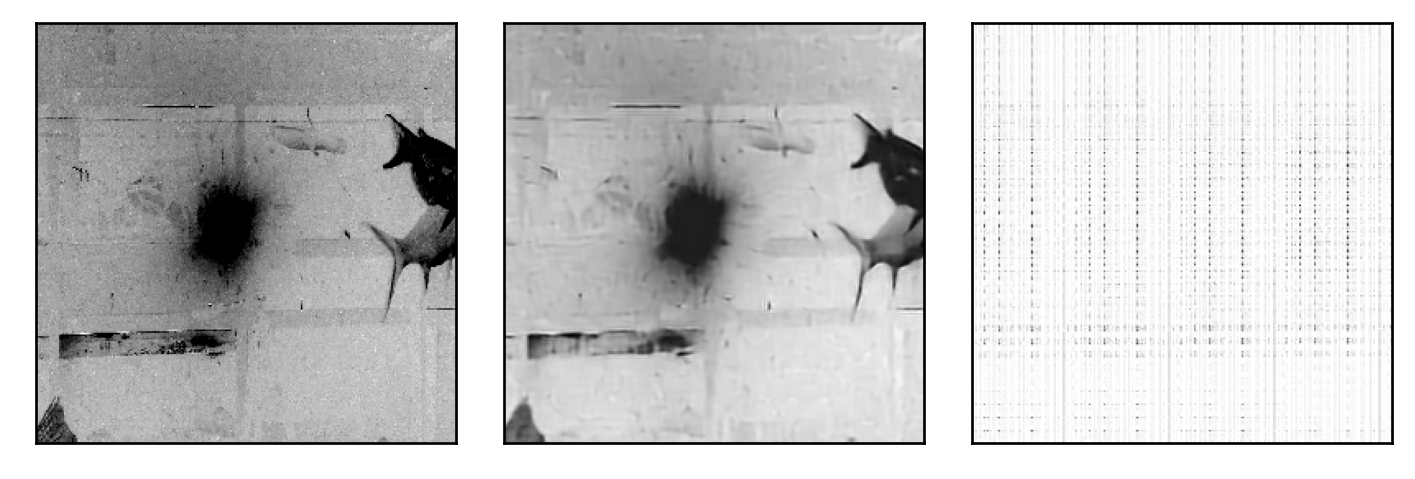

In [118]:
fig, (ax0, ax1, ax2) = plt.subplots(dpi=240, ncols=3)

ax0.imshow(my_faint_images[i].reshape(max_dim[0], max_dim[1]), cmap=plt.cm.binary)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

ax1.imshow(decoded_imgs[i].reshape(max_dim[0], max_dim[1]), cmap=plt.cm.binary)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.imshow(encoded_imgs[i].reshape(max_dim[0], max_dim[1]), cmap=plt.cm.binary)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()